In [4]:
import re
import json
import hashlib
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
METADATA_CSV = "metadata.csv"
GENOMIC_NUCLEOTIDE_CSV = "genomic.csv"
PROTEIN_CSV = "protein.csv"

In [6]:
df = pd.read_csv(METADATA_CSV)
dfg = pd.read_csv(GENOMIC_NUCLEOTIDE_CSV)
dfp = pd.read_csv(PROTEIN_CSV)

In [7]:
print(f"Metadata shape {df.shape}")

Metadata shape (41679, 7)


In [8]:
print(f"Genomic shape {dfg.shape}")

Genomic shape (41762, 3)


In [9]:
print(f"Protein shape {dfg.shape}")

Protein shape (41762, 3)


In [10]:
# join genomic data to metadata
df = df.join(dfg.set_index('accession'), on='accession')

In [11]:
# join protein data to metadata
df = df.join(dfp.set_index('accession'), on='protein_accession')
df.rename(columns={"protein":"sgene_protein", "protein_desc":"sgene_protein_desc"}, inplace=True)

In [12]:
df.dropna(inplace=True)

In [13]:
def cut_sgene(row):
    begin = int(row['sgene_begin']) - 1
    end = int(row['sgene_end'])
    sgene = row['genome'][begin:end]
    return sgene

with pd.option_context('mode.chained_assignment', None):
    df['sgene_nucleotide'] = df.apply(cut_sgene, axis=1)

In [14]:
df

,accession,protein_accession,collection_date,sgene_begin,sgene_end,location,region,genome,genome_desc,sgene_protein,sgene_protein_desc,sgene_nucleotide
0,MN908947.3,QHD43416.1,2019-12,21563,25384,China,Asia,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
1,NC_045512.2,YP_009724390.1,2019-12,21563,25384,China,Asia,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
2,MN985325.1,QHO60594.1,2020-01-19,21563,25384,USA,North America,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
3,MN975262.1,QHN73810.1,2020-01-11,21563,25384,China,Asia,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
4,MN938384.1,QHN73795.1,2020-01-10,21531,25352,China: Shenzhen,Asia,CAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
...,...,...,...,...,...,...,...,...,...,...,...,...
41674,MW617535.1,QRU91038.1,2021-01-31,21532,25353,USA: Georgia,North America,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
41675,MW617534.1,QRU91026.1,2021-01-30,21535,25356,USA: Louisiana,North America,AAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
41676,MW617533.1,QRU91014.1,2021-01-31,21532,25353,USA: California,North America,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTT...,Severe acute respiratory syndrome coronavirus ...,MFVFFVLLPLVSIQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTTTTGTTTTATTGCCACTAGTCTCTATTCAGTGTG...
41677,MW617516.1,QRU90810.1,2021-02-02,21558,25379,USA: California,North America,AGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSIQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTATTCAGTGTG...


In [15]:
df.to_csv("ncbi_sgene_nuc_pro_full.csv", index=False)

In [16]:
with open("ncbi_sgene_nuc_full.fasta", "w") as fasta_file:
    for _, row in df.iterrows():
        fasta_file.write(f">{row['accession']}\n")
        fasta_file.write(f"{row['sgene_nucleotide']}\n")

### Good sgenes

In [17]:
letters = ['R', 'M', "S", "B", "H", "N", "Y", "K", "W", "D", "V"]
df_good = df[~df['sgene_nucleotide'].str.contains("|".join(letters))]

with open("ncbi_sgene_nuc_good.fasta", "w") as fasta_file:
    for _, row in df_good.iterrows():
        fasta_file.write(f">{row['accession']}\n")
        fasta_file.write(f"{row['sgene_nucleotide']}\n")

In [18]:
df_good

,accession,protein_accession,collection_date,sgene_begin,sgene_end,location,region,genome,genome_desc,sgene_protein,sgene_protein_desc,sgene_nucleotide
0,MN908947.3,QHD43416.1,2019-12,21563,25384,China,Asia,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
1,NC_045512.2,YP_009724390.1,2019-12,21563,25384,China,Asia,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
2,MN985325.1,QHO60594.1,2020-01-19,21563,25384,USA,North America,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
3,MN975262.1,QHN73810.1,2020-01-11,21563,25384,China,Asia,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
4,MN938384.1,QHN73795.1,2020-01-10,21531,25352,China: Shenzhen,Asia,CAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
...,...,...,...,...,...,...,...,...,...,...,...,...
41674,MW617535.1,QRU91038.1,2021-01-31,21532,25353,USA: Georgia,North America,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
41675,MW617534.1,QRU91026.1,2021-01-30,21535,25356,USA: Louisiana,North America,AAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...
41676,MW617533.1,QRU91014.1,2021-01-31,21532,25353,USA: California,North America,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTT...,Severe acute respiratory syndrome coronavirus ...,MFVFFVLLPLVSIQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTTTTGTTTTATTGCCACTAGTCTCTATTCAGTGTG...
41677,MW617516.1,QRU90810.1,2021-02-02,21558,25379,USA: California,North America,AGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSIQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1-1273 surface glycoprotein [organism=Severe a...,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTATTCAGTGTG...


### Good unique sgenes 

In [19]:
# Groupby by sgene
g = df_good.groupby("sgene_nucleotide")

# Create list of accession names of that sgene
df_good_unique = g["accession"].apply(lambda values: "|".join(values)).to_frame()
df_good_unique.rename(columns={"accession": "accessions"}, inplace=True)

# Create new column as sum
df_good_unique["accessions_count"] = g["accession"].count()
df_good_unique.reset_index(inplace=True)

# Create new accession "{count of duplicates}_{sgene hash}"
df_good_unique["accession"] = df_good_unique.apply(lambda x: f"{x['accessions_count']}_{hashlib.md5(x['sgene_nucleotide'].encode()).hexdigest()}", axis=1) 

df_good_unique.to_csv("ncbi_sgene_good_unique.csv", index=False)

In [20]:
df_good_unique

,sgene_nucleotide,accessions,accessions_count,accession
0,AGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCC...,MT970416.1,1,1_07011ff250ef4a4ace2ef9b43d5c2ba1
1,ATGCTTGTTTTTTTTTTTGTTTTATTGCCACTAGTCTCTAGTCAGT...,MW540269.1|MW540268.1,2,2_059f461871887e99ab81c93d6be95c63
2,ATGTATGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,MW467454.1,1,1_048ae97f946c3ec03e7a1e6e85022dd5
3,ATGTTAGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,MT496989.1|MT535500.1,2,2_db94be2d798aced9967b7540b04c6e4f
4,ATGTTAGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,MW206350.1|MW206333.1|MW420547.1|MW420251.1,4,4_d7f6e71507ff532913077e139a1200ee
...,...,...,...,...
4379,ATGTTTGTTTTTTTTTTTGTTTTATTGCCACTAGTCTCTAGTCAGT...,MW460643.1,1,1_1c35868a205decc006af1af9332de520
4380,ATGTTTTTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,MT873167.1,1,1_f99d371f32ad020303cb3ca0946b9773
4381,ATGTTTTTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,MT972160.1,1,1_85a663a10c0508eb03015b0d62f4a05b
4382,CAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATT...,MT970387.1,1,1_bc8364434f1c405884ffb19232630d57


In [21]:
with open("ncbi_sgene_good_unique.fasta", "w") as fasta_file:
    for _, row in df_good_unique.iterrows():
        fasta_file.write(f">{row['accession']}\n")
        fasta_file.write(f"{row['sgene_nucleotide']}\n")

### Bad sgenes (with N, R, letters)

In [22]:
df_bad = df[df['sgene_nucleotide'].str.contains("|".join(letters))]

In [23]:
for letter in letters:
    df_bad[letter] = df_bad['sgene_nucleotide'].str.count(letter)

<ipython-input-23-71a25e765992>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bad[letter] = df_bad['sgene_nucleotide'].str.count(letter)


In [24]:
df_bad

,accession,protein_accession,collection_date,sgene_begin,sgene_end,location,region,genome,genome_desc,sgene_protein,...,M,S,B,H,N,Y,K,W,D,V
5,MN988713.1,QHO62877.1,2020-01-21,21563,25384,USA: Illinois,North America,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,0,1,0,0,0,0
89,MT233522.1,QIQ08820.1,2020-03-02,21509,25330,Spain: Valencia,Europe,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,81,0,0,0,0,0
100,MT246482.1,QIQ50092.1,2020-03-15,21506,25327,USA: WA,North America,TCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGC...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,3,0,0,0,0,0
118,MT246463.1,QIQ49902.1,2020-03-13,21437,25258,USA: WA,North America,GTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,40,0,0,0,0,0
125,MT246456.1,QIQ49832.1,2020-03-13,21506,25327,USA: WA,North America,TCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGC...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41648,MW617567.1,QRU91422.1,2021-02-01,21532,25353,USA: California,North America,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSIQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,111,0,0,0,0,0
41651,MW617564.1,QRU91386.1,2021-01-28,21528,25349,USA: Connecticut,North America,CCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,41,0,0,0,0,0
41653,MW617561.1,QRU91350.1,2021-01-30,21528,25349,USA: Florida,North America,CAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTT...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,4,0,0,0,0,0
41654,MW617560.1,QRU91338.1,2021-01-30,21539,25360,USA: Indiana,North America,TAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA...,Severe acute respiratory syndrome coronavirus ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,...,0,0,0,0,18,0,0,0,0,0


In [25]:
bars = {}
for letter in letters:
    c = df_bad[df_bad[letter]>0][letter].count()
    print(f'{letter} {c}')
    bars[letter]=c


R 264
M 115
S 67
B 2
H 3
N 2512
Y 453
K 214
W 93
D 3
V 25


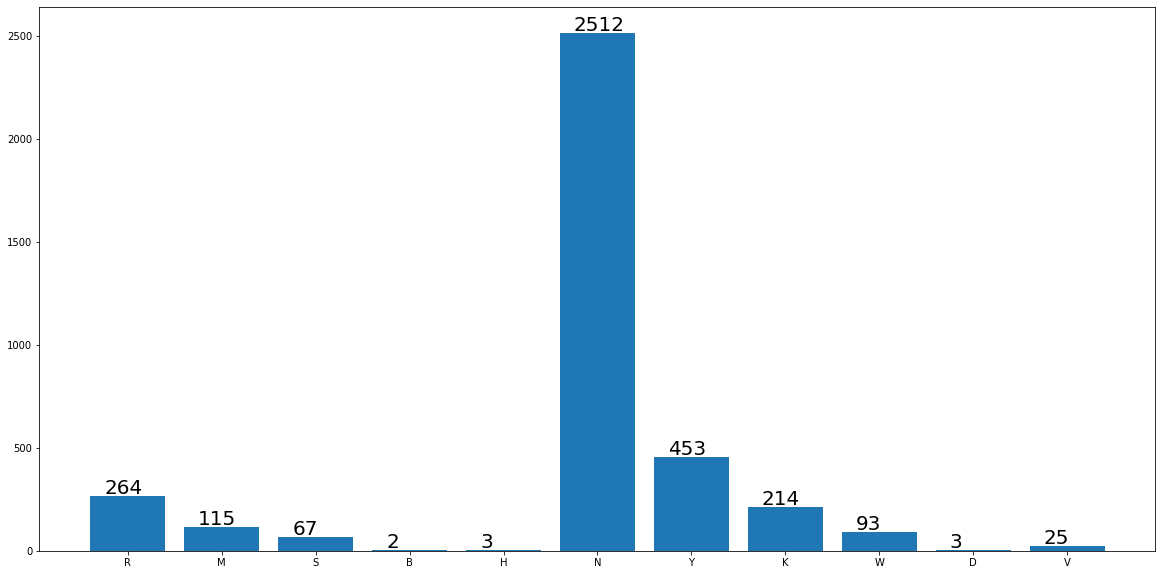

In [26]:
plt.figure(figsize=(20,10))
plt.bar(bars.keys(), bars.values())
for i, v in enumerate(bars.values()):
    plt.text(x=i-0.25 , y=v+10 , s=f"{v}", fontsize=20)

In [27]:
with open("good_unique_o.aln", "r") as gu_file:
    good_unique_aln = gu_file.read()

In [36]:
for i, row in df_good_unique.iterrows():
    if (i > 0) and (i % 100 == 0):
        print(i)
    p = re.compile(f"({row['accessions']})")
    good_unique_aln = p.sub(row['accession'], good_unique_aln)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300


In [37]:
with open("good_unique.aln", "w") as gu_file:
    gu_file.write(good_unique_aln)